In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
import os
from ML_for_GreenImaging.PipelineStages import *
from tensorflow.keras import models, optimizers, layers, metrics

2023-07-16 17:27:35.468405: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Getting Data

In [2]:
data_path = "/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:15:23"

In [3]:
data_path = "/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:15:23"
file  = "fIdx=3343893,runPhaseIndex=290,gateSequenceScanValue2=0,tweezerPowerLow_mW=1400.000000000,gateSequenceScanValue=0.000020000,iterator=71.000000000"
nuvu = loadmat(f"{data_path}/nuvu/nuvuCam,{file}.mat")
pv_cam = loadmat(f"{data_path}/pvcam/camera,{file}.mat")

pv_stack = []
nuvu_stack = []
n_files = 0

for file in os.listdir(data_path + "/pvcam/"):
    if file.endswith('.mat'):
        name = file.split(',', 1)
        if os.path.exists(f"{data_path}/nuvu/nuvuCam,{name[1]}"):
            pv_stack.append(loadmat(f"{data_path}/pvcam/{file}")['stack'])
            nuvu_stack.append(loadmat(f"{data_path}/nuvu/nuvuCam,{name[1]}")['stack'])
            n_files += 1

# First file seems to be from beginning of the loop. Second one, unsure?
pv_stack = np.concatenate(pv_stack, axis=0)
nuvu_stack = np.concatenate(nuvu_stack, axis=0)

In [4]:
print(pv_stack.shape)
print(nuvu_stack.shape)

(14400, 80, 80)
(7200, 100, 100)


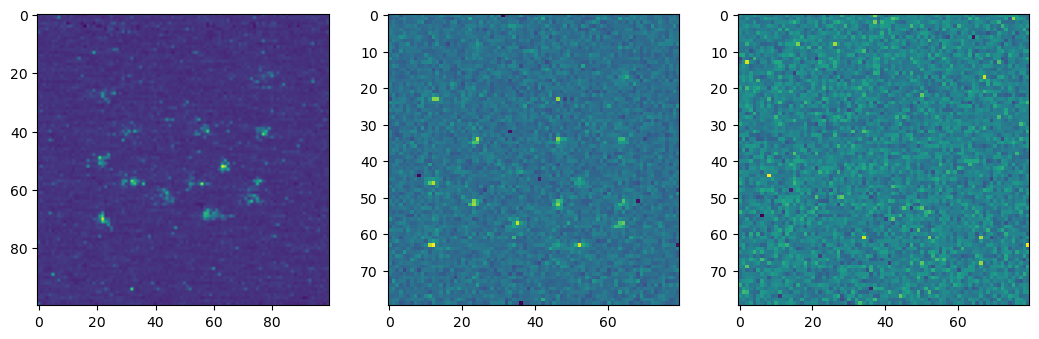

In [5]:
i = 100

fig, axs = plt.subplots(1, 3, figsize=(12.8, 6.4))
axs[0].imshow(nuvu_stack[i])
axs[1].imshow(pv_stack[2 * i])
axs[2].imshow(pv_stack[2 * i + 1])

Text(0.5, 1.0, 'nuvuCam')

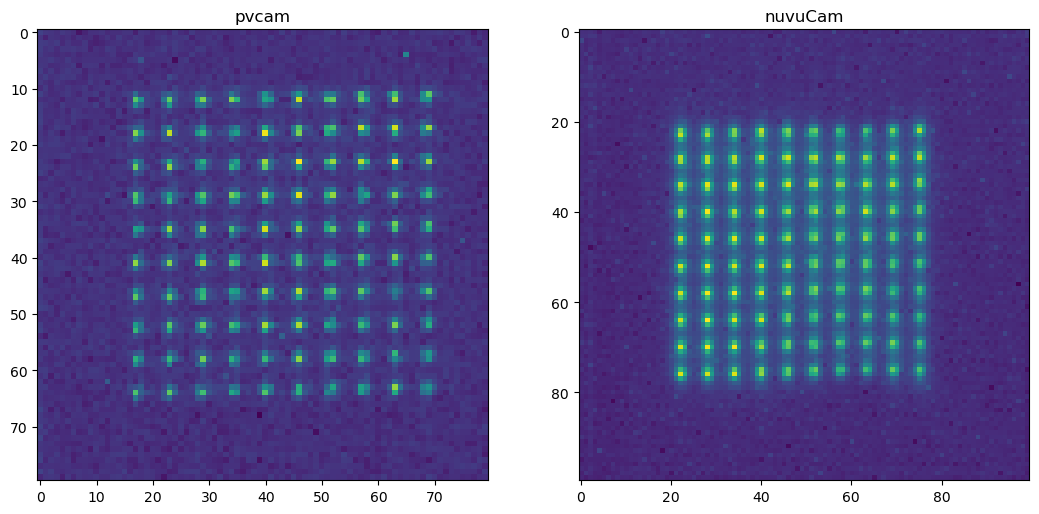

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4))
axs[1].imshow(np.sum(nuvu_stack, axis=0).T)
axs[0].imshow(np.sum(pv_stack[::2], axis=0).T)

axs[0].set_title("pvcam")
axs[1].set_title("nuvuCam")


# Getting Positions from pvcam Image

In [7]:
pv_processor = ImageProcessing.ImageProcessor(pv_stack, 100, 10)

In [8]:
pv_positions = pv_processor.find_tweezer_positions()

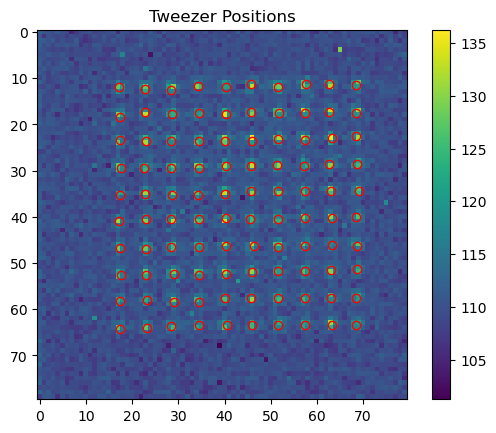

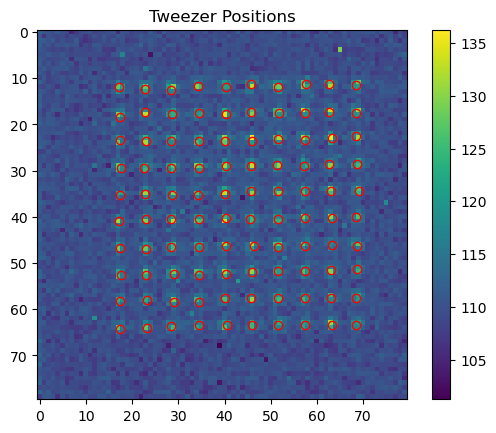

In [9]:
pv_processor.plot()

# Testing OpenCV for Affine Transform

In [10]:
def convert_uint8(img):
    img = 255 * (img - np.min(img)) / (img.max() - img.min())
    return img.astype('uint8')

In [11]:
orb = cv2.ORB_create(edgeThreshold=10)

Pick three random images in the stack, filter them, and then try to calculate the affine transform by brute force matching keypoints.

In [12]:
indices = np.random.choice(nuvu_stack.shape[0], size=10, replace=False)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
orb = cv2.ORB_create(edgeThreshold=10)
pv_pts = []
nuvu_pts = []
for i in indices:
    nuvu_img = convert_uint8(nuvu_stack[i])
    pv_img = convert_uint8(pv_stack[2 * i])
    nuvu_img = cv2.bilateralFilter(nuvu_img, 5, 25, 25)
    pv_img = cv2.bilateralFilter(pv_img, 5, 25, 25)
    nuvu_keypoints, nuvu_descriptors = orb.detectAndCompute(nuvu_img.T, None)
    pv_keypoints, pv_descriptors = orb.detectAndCompute(pv_img.T, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(pv_descriptors, nuvu_descriptors)
    #matches = sorted(matches, key=lambda x: x.distance)
    pv_pts.extend([pv_keypoints[m.queryIdx].pt for m in matches])
    nuvu_pts.extend([nuvu_keypoints[m.trainIdx].pt for m in matches])
affine_mat, _ = cv2.estimateAffine2D(np.array(pv_pts), np.array(nuvu_pts))
nuvu_positions = np.reshape(cv2.transform(np.reshape(pv_positions, (-1, 1, 2)), affine_mat), (-1, 2))


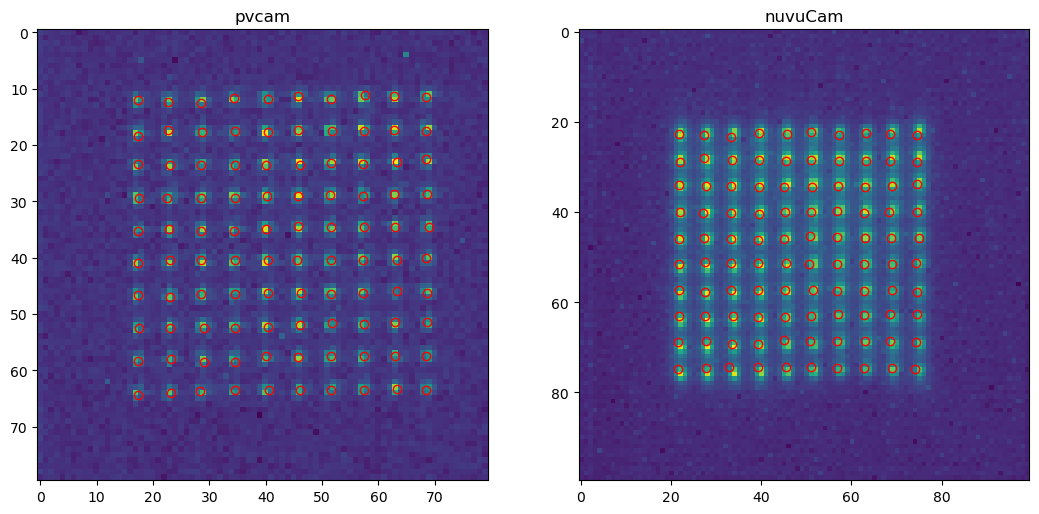

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4))

axs[0].imshow(np.mean(pv_stack[::2], axis=0).T)
axs[1].imshow(np.mean(nuvu_stack, axis=0).T)

for nuvu_pos, pv_pos in zip(nuvu_positions, pv_positions):
    axs[0].plot(*pv_pos, 'ro', fillstyle="none")
    axs[0].set_title("pvcam")
    axs[1].plot(*nuvu_pos, 'ro', fillstyle="none")
    axs[1].set_title("nuvuCam")

# Make Training Dataset

In [14]:
pv_processor = ImageProcessing.ImageProcessor(pv_stack[::2], 100, 10)

In [16]:
pv_processor.find_tweezer_positions()
pv_nn_dist = pv_processor.find_nn_dist()
pv_positions = pv_processor.position_tile_sort(pv_nn_dist)
pv_crops = pv_processor.crop_tweezers(3, pv_nn_dist)

In [17]:
nuvu_positions = np.reshape(cv2.transform(np.reshape(pv_positions, (-1, 1, 2)), affine_mat), (-1, 2))

In [25]:
nuvu_processor = ImageProcessing.ImageProcessor(nuvu_stack, 100, 10, tweezer_positions=nuvu_positions)
nuvu_nn_dist = nuvu_processor.find_nn_dist()
nuvu_crops = nuvu_processor.crop_tweezers(3, nuvu_nn_dist)

In [26]:
model = models.load_model("/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:23:23/imaging exposure time = 15ms/model.h5")

In [27]:
pv_crops_3x3 = np.reshape(pv_crops, (-1, *pv_crops.shape[-2:]))
labels = model.predict(pv_crops_3x3)

22500/22500 [==============================] - 53s 2ms/step


In [28]:
occ = np.argmax(labels, axis=1)
labels = np.transpose(np.array([np.absolute(1 - occ), occ]))

1


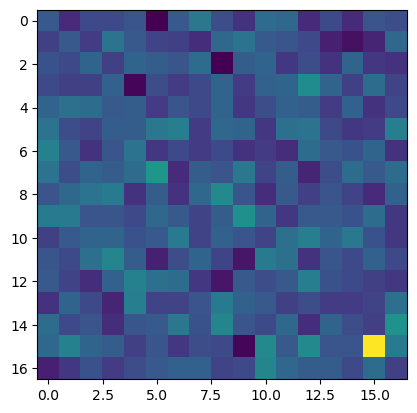

In [29]:
random_index = np.random.randint(len(labels))
plt.imshow(pv_crops_3x3[random_index])
print(np.argmax(labels[random_index]))

# Training Blue Model

In [30]:
def architecture_1(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.RandomFlip())
    network.add(layers.Normalization())
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.Flatten())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

def architecture_3(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.RandomFlip())
    network.add(layers.Normalization())
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.Flatten())
    network.add(layers.Dense(n_filters[1], activation='sigmoid'))
    network.add(layers.BatchNormalization())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

def architecture_4(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.RandomFlip())
    network.add(layers.Normalization())
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.Flatten())
    network.add(layers.Dense(n_filters[1], activation='sigmoid'))
    network.add(layers.BatchNormalization())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

In [35]:
nuvu_crops = np.reshape(nuvu_crops, (-1, *nuvu_crops.shape[-2:]))
nuvu_model = architecture_3(nuvu_crops.shape[-2:], [32, 16], [3, 3])
nuvu_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy',
               metrics=['binary_accuracy'])

In [36]:
nuvu_model.fit(nuvu_crops, labels, epochs=8, validation_split=0.1)

Epoch 1/8
20250/20250 [==============================] - 197s 10ms/step - loss: 0.2492 - binary_accuracy: 0.9139 - val_loss: 0.2772 - val_binary_accuracy: 0.8980
Epoch 2/8
20250/20250 [==============================] - 194s 10ms/step - loss: 0.2295 - binary_accuracy: 0.9231 - val_loss: 0.2780 - val_binary_accuracy: 0.8981
Epoch 3/8
20250/20250 [==============================] - 197s 10ms/step - loss: 0.2251 - binary_accuracy: 0.9252 - val_loss: 0.2602 - val_binary_accuracy: 0.9068
Epoch 4/8
20250/20250 [==============================] - 198s 10ms/step - loss: 0.2221 - binary_accuracy: 0.9265 - val_loss: 0.2572 - val_binary_accuracy: 0.9088
Epoch 5/8
20250/20250 [==============================] - 198s 10ms/step - loss: 0.2196 - binary_accuracy: 0.9279 - val_loss: 0.2557 - val_binary_accuracy: 0.9094
Epoch 6/8
20250/20250 [==============================] - 198s 10ms/step - loss: 0.2181 - binary_accuracy: 0.9285 - val_loss: 0.2601 - val_binary_accuracy: 0.9073
Epoch 7/8
20250/20250 [=====

In [ ]:
predicted_labels = nuvu_model.predict(nuvu_crops)

22500/22500 [==============================] - 73s 3ms/step


In [ ]:
where_wrong = np.argmax(predicted_labels, axis=1) != np.argmax(labels, axis=1)
wrong_crops = nuvu_crops[where_wrong]
wrong_labels = np.argmax(labels[where_wrong], axis=1)
indices = np.arange(labels.shape[0])[where_wrong]

Green NN said: 1
Blue NN said: 0


Text(0.5, 1.0, 'Blue')

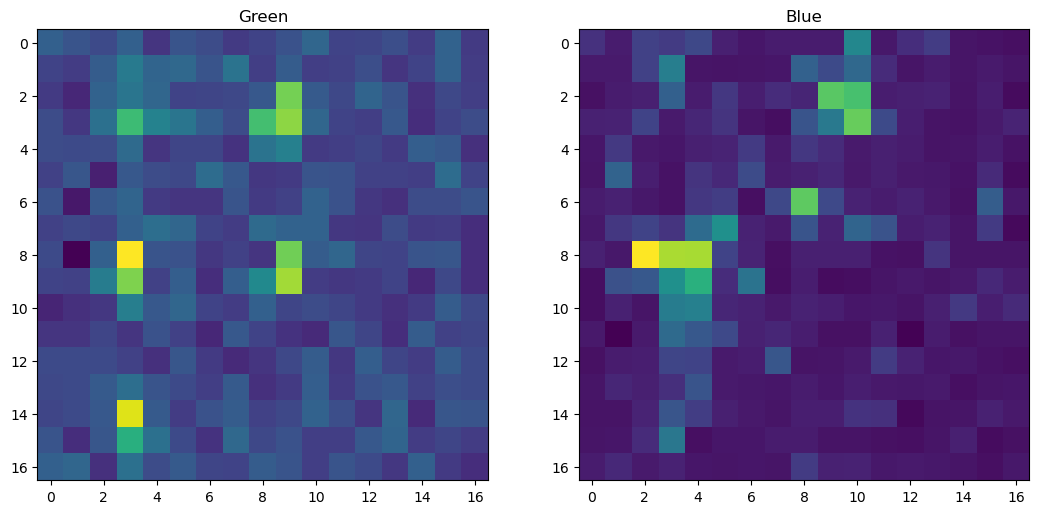

In [ ]:
random_index = np.random.randint(len(wrong_labels))

print(f"Green NN said: {np.argmax(labels[indices[random_index]])}")
print(f"Blue NN said: {np.argmax(wrong_labels[random_index])}")

fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4))

axs[0].imshow(pv_crops_3x3[indices[random_index]].T)
axs[0].set_title("Green")
axs[1].imshow(wrong_crops[random_index].T)
axs[1].set_title("Blue")

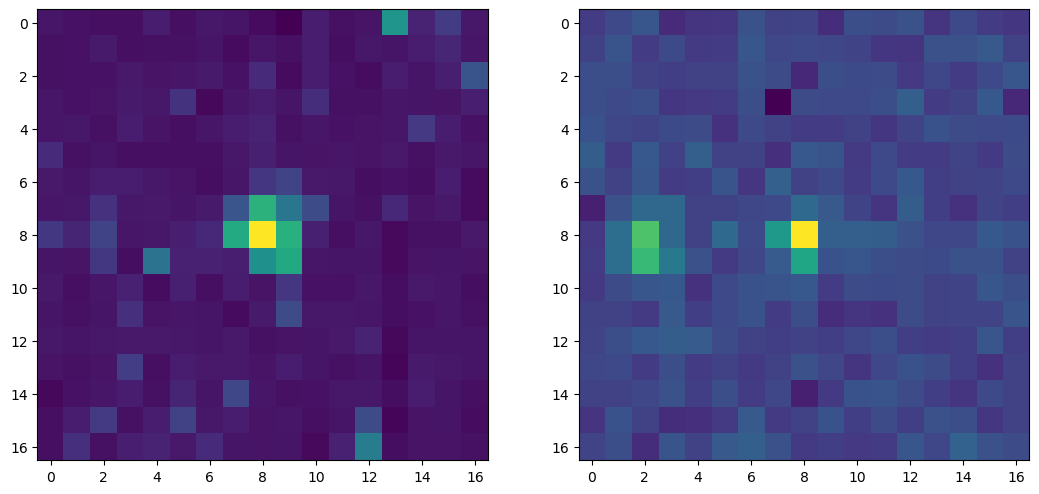

In [ ]:
random_index = np.random.randint(len(labels))

fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4))

axs[1].imshow(pv_crops_3x3[random_index].T)
axs[0].imshow(nuvu_crops[random_index].T)

In [ ]:
print(np.sum(labels[:, 0], axis=0), np.sum(labels[:, 1], axis=0))

364073.94 356862.88


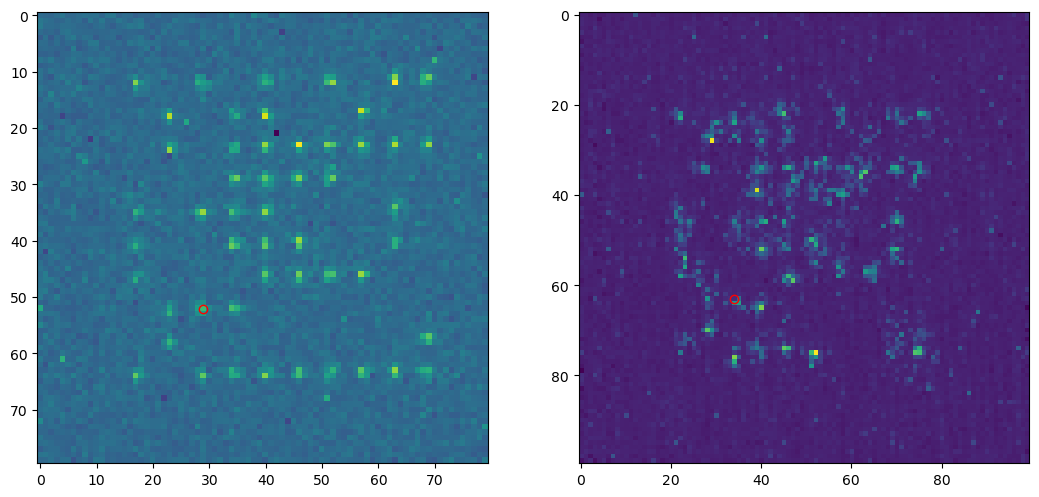

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4))

axs[0].imshow(pv_stack[2 * 2467].T)
axs[0].plot(*pv_positions[72], 'ro', fillstyle='none')
axs[1].imshow(nuvu_stack[2467].T)
axs[1].plot(*nuvu_positions[72], 'ro', fillstyle='none')
